In [1]:
import os, shutil
from keras import models
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sp
from scipy.stats import kde
import importlib as im
import cnn_utilities as cn

Using TensorFlow backend.


In [2]:
# load trained model and normalization values
mymodel = models.load_model("saved_models/train_128batch_20epoch_R0_sampleRate_migrationRate.hdf5")

mean_sd = pd.read_csv("saved_models/train_128batch_20epoch_normalization_label_mean_sd.csv", 
                     index_col = 0).to_numpy()

train_means = mean_sd[0,:]
train_sd = mean_sd[1,:]
train_aux_priors_means = train_means[3:,]
train_aux_priors_sd = train_sd[3:,]

num_locs = 5
max_tips = 502


In [3]:
phylo_comparison_data = pd.read_csv("data_files/cblv_files/phylo_comparison_set.cblv.csv", 
                   header =None, error_bad_lines = False).to_numpy()

phylo_comparison_labels = pd.read_csv("data_files/label_files/phylo_comparison_loc_R0_delta_migration_treelength_meanbl_set_0to25.csv",
                    header = None, error_bad_lines = False).to_numpy()

phylo_post = pd.read_table("data_files/phylo_estimates_files/true_model_3params_R0_delta_migr.postmeans", 
                   header = None, index_col = 0, error_bad_lines = False).to_numpy()


In [5]:
########################################
# comapre APE of CNN to that of phylo ##
########################################
# revbayes output
phylo_labels = phylo_comparison_labels.copy()[:,5:8]

phylo_post_ape = 100 * np.abs((phylo_labels - phylo_post)/phylo_labels)

# compute and gather auxilliary prior data
phylocomp_subsample_prop = phylo_comparison_data[:,(max_tips-1) * 7]
phylcomp_mu = phylo_comparison_data[:,(max_tips - 3) * 7]
phylocomp_num_tips = cn.get_num_tips(phylo_comparison_data)

aux_phylocomp = np.vstack((phylcomp_mu, phylocomp_subsample_prop, phylocomp_num_tips,
                          phylo_comparison_labels[:,8], phylo_comparison_labels[:,9])).transpose()

norm_aux_phylocomp = cn.normalize(aux_phylocomp, (train_aux_priors_means, train_aux_priors_sd))


# create input tensors
phylocomp_treeLocation_tensor, phylocomp_prior_tensor = cn.create_data_tensors(data = phylo_comparison_data, 
                                                                                    mu = norm_aux_phylocomp[:,0],
                                                                                    subsample_prop = norm_aux_phylocomp[:,1],
                                                                                    num_tips = norm_aux_phylocomp[:,2],
                                                                                    tmrca = norm_aux_phylocomp[:,3],
                                                                                    mean_bl = norm_aux_phylocomp[:,4],
                                                                                    num_locs = num_locs,
                                                                                    max_tips = max_tips,
                                                                                    cblv_contains_mu_rho = True)



In [6]:
# PREDICT
phylocomp_normalized_preds = mymodel.predict([phylocomp_treeLocation_tensor, phylocomp_prior_tensor])

# reversing normalization
cnn_phylocomp_preds = cn.denormalize(phylocomp_normalized_preds, train_means[0:3], train_sd[0:3])
cnn_phylocomp_preds[:,1:3] = np.exp(cnn_phylocomp_preds[:,1:3])




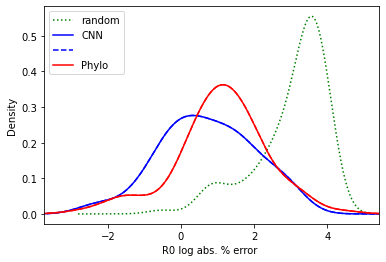

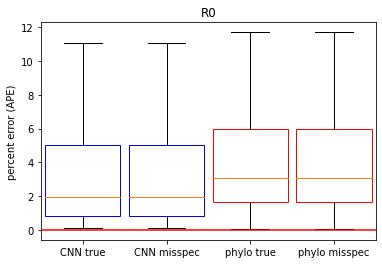

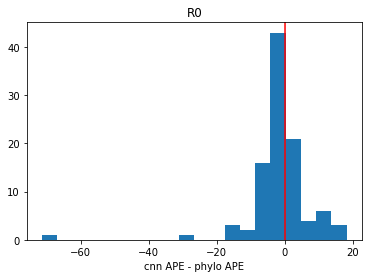

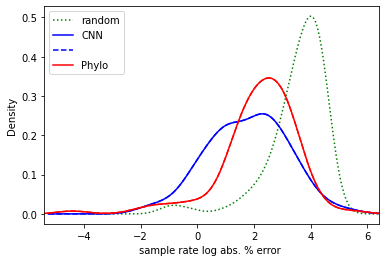

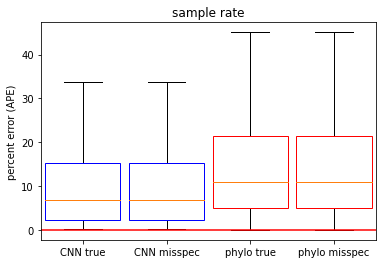

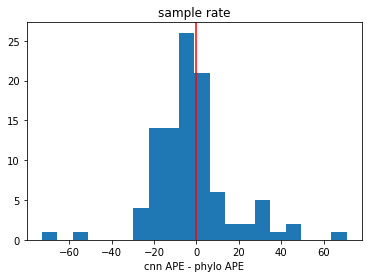

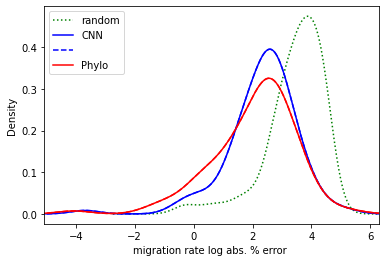

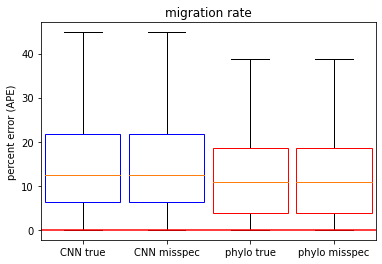

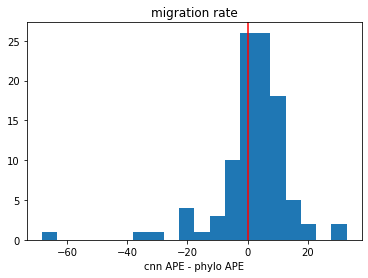

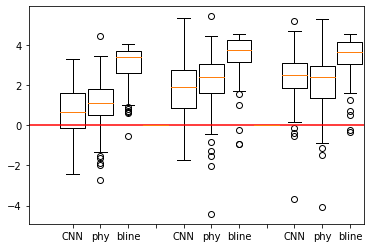

In [7]:
# make plots
cnn_phylocomp_ape = 100 * np.abs((cnn_phylocomp_preds - phylo_labels)/phylo_labels)
mean_bl_R0 = 2 + (8 - 2)/2
mean_bl_delta = 0.0001 + (0.005 - 0.0001)/2
mean_bl_migration = 0.0001 + (0.005 - 0.0001)/2
mean_bl_R0_ape = 100 * np.abs(phylo_labels[:, 0] - mean_bl_R0)/mean_bl_R0
mean_bl_sample_ape = 100 * np.abs(phylo_labels[:, 1] - mean_bl_delta)/mean_bl_delta
mean_bl_migration_ape = 100 * np.abs(phylo_labels[:, 2] - mean_bl_migration)/mean_bl_migration
baseline_ape = np.column_stack((mean_bl_R0_ape, mean_bl_sample_ape, mean_bl_migration_ape))


cn.make_experiment_density_plots(cnn_phylocomp_ape, phylo_post_ape,
                       cnn_phylocomp_ape, phylo_post_ape, baseline_ape,
                          plot_legend = ["random", "CNN", "", "Phylo", ])

plt.boxplot([np.log(cnn_phylocomp_ape[:,0]), np.log(phylo_post_ape[:,0]), np.log(baseline_ape[:,0]), 0,
            np.log(cnn_phylocomp_ape[:,1]), np.log(phylo_post_ape[:,1]), np.log(baseline_ape[:,1]), 0,
            np.log(cnn_phylocomp_ape[:,2]), np.log(phylo_post_ape[:,2]), np.log(baseline_ape[:,2])],
           widths=0.9,
            labels = ["CNN", "phy", "bline", "",
                     "CNN", "phy", "bline", "",
                     "CNN", "phy", "bline"])
plt.axline((0,0),slope=0,color="red")
plt.show()


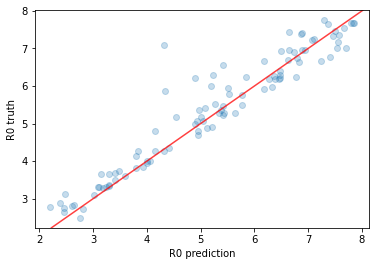

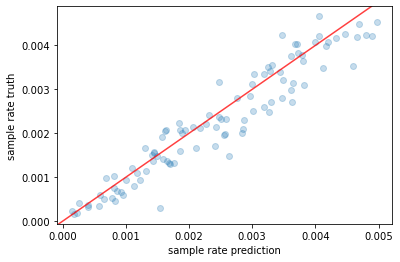

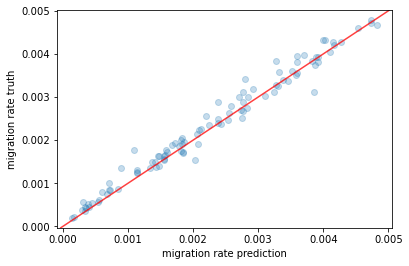

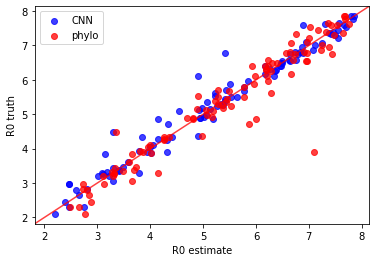

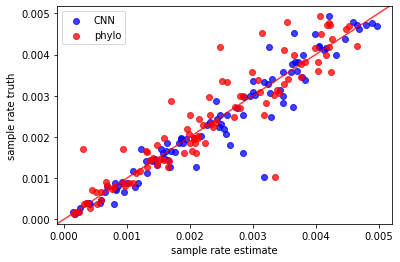

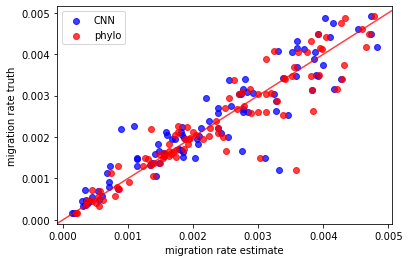

In [8]:
cn.plot_preds_labels(cnn_phylocomp_preds, phylo_post,
                         param_names = ["R0", "sample rate", "migration rate"])

cn.plot_overlaid_scatter(cnn_phylocomp_preds, phylo_post,
                         phylo_labels, 
                         param_names = ["R0", "sample rate", "migration rate"])

[cn.qq_plot(np.log(cnn_phylocomp_ape[:,i]), np.log(phylo_post_ape[:,i]), num_quantiles = 20) for i in range(0,3)]

In [10]:
# print percent absolute error medians

# look into wasserstein distances from baseline: scipy.stats.wasserstein_distance()

print("R0")
print("mean difference in APE (CNN_APE - Phylo_APE): ",  np.mean(cnn_phylocomp_ape[:,0] - phylo_post_ape[:,0]))
print(np.median(phylo_post_ape[:,0]), np.quantile(phylo_post_ape[:,0], [0.025, 0.975]))
print(np.median(cnn_phylocomp_ape[:,0]), np.quantile(cnn_phylocomp_ape[:,0], [0.025, 0.975]))
print(np.median(baseline_ape[:,0]), np.quantile(baseline_ape[:,0], [0.025, 0.975]))
# bins = np.arange(1,10, step = 0.5)[0]
# print("  KL ratio: ", (sp.entropy(np.histogram(cnn_phylocomp_ape[:,0], bins=bins),  np.histogram(mean_bl_R0_ape, bins=bins))/ 
#                        sp.entropy(np.histogram(phylo_post_ape[:,0], np.histogram(mean_bl_R0_ape)))
print("delta")
print("mean difference in APE (CNN_APE - Phylo_APE): ",  np.mean(cnn_phylocomp_ape[:,1] - phylo_post_ape[:,1]))
print(np.median(phylo_post_ape[:,1]), np.quantile(phylo_post_ape[:,1], [0.025, 0.975]))
print(np.median(cnn_phylocomp_ape[:,1]), np.quantile(cnn_phylocomp_ape[:,1], [0.025, 0.975]))
print(np.median(baseline_ape[:,1]), np.quantile(baseline_ape[:,1], [0.025, 0.975]))
# print("  KL ratio: ", (sp.entropy(np.histogram(cnn_phylocomp_ape[:,1], bins=bins), np.histogram(mean_bl_sample_ape, bins=bins) ) / 
#                        sp.entropy(np.histogram(phylo_post_ape[:,1], bins=bins), np.histogram(mean_bl_sample_ape, bins=bins))))
print("migration")
print("mean difference in APE (CNN_APE - Phylo_APE): ",  np.mean(cnn_phylocomp_ape[:,2] - phylo_post_ape[:,2]))
print(np.median(phylo_post_ape[:,2]), np.quantile(phylo_post_ape[:,2], [0.025, 0.975]))
print(np.median(cnn_phylocomp_ape[:,2]), np.quantile(cnn_phylocomp_ape[:,2], [0.025, 0.975]))
print(np.median(baseline_ape[:,2]), np.quantile(baseline_ape[:,2], [0.025, 0.975]))
# print("  KL ratio: ", (sp.entropy(np.histogram(cnn_phylocomp_ape[:,2], bins=bins), np.histogram(mean_bl_migration_ape, bins=bins)) / 
#                        sp.entropy(np.histogram(phylo_post_ape[:,2], bins=bins), np.histogram(mean_bl_migration_ape, bins=bins))))

# cn.plot_preds_labels(phylo_post, phylo_labels)
# cn.plot_preds_labels(cnn_phylocomp_preds, phylo_labels)


R0
mean difference in APE (CNN_APE - Phylo_APE):  -1.6658454612044509
3.0898447948912695 [ 0.16928646 25.59259591]
1.9356007219763978 [ 0.13605135 19.80092291]
29.7691 [ 1.99614  56.117725]
delta
mean difference in APE (CNN_APE - Phylo_APE):  -2.1477199691757103
10.871104082282795 [ 0.24279179 51.80618819]
6.793217073317685 [ 0.36188421 71.73438879]
43.13725490196078 [ 1.71568627 93.14705882]
migration
mean difference in APE (CNN_APE - Phylo_APE):  1.6171120742685678
10.786720092468759 [ 0.3674628  61.60586594]
12.400712605014553 [ 0.77010062 62.9137569 ]
37.54939215686275 [ 1.86304706 91.97673725]


In [11]:
#########################################
# sample rate misspecified model trees ##
#########################################
misspec_delta_data = pd.read_csv("data_files/cblv_files/misspec_delta.cblv.csv", 
                   header =None, error_bad_lines = False).to_numpy()
# load labels data
misspec_delta_labels = pd.read_csv("data_files/label_files/alt_loc_R0_delta_migration_treelength_meanbl_misspec_delta.csv",
                    header = None, error_bad_lines = False).to_numpy()



In [12]:
#########################
# prepare input tensors #
#########################


# normalize with training means and sds
misspec_delta_subsample_prop = misspec_delta_data[:,(max_tips-1) * 7]
misspec_delta_mu = misspec_delta_data[:,(max_tips-3) * 7]
misspec_delta_num_tips = cn.get_num_tips(misspec_delta_data)
misspec_delta_tmrca = misspec_delta_labels[:,8]
misspec_delta_mean_bl = misspec_delta_labels[:,9]

aux_misspec_delta = np.vstack((misspec_delta_mu, misspec_delta_subsample_prop, misspec_delta_num_tips,
                              misspec_delta_tmrca, misspec_delta_mean_bl)).transpose()
norm_aux_misspec_delta = cn.normalize(aux_misspec_delta, (train_aux_priors_means, train_aux_priors_sd))

misspec_delta_treeLocation_tensor, misspec_delta_prior_tensor = cn.create_data_tensors(misspec_delta_data,
                                                                          mu = norm_aux_misspec_delta[:,0],
                                                                          subsample_prop = norm_aux_misspec_delta[:,1],
                                                                            num_tips = norm_aux_misspec_delta[:,2],
                                                                            tmrca = norm_aux_misspec_delta[:,3],
                                                                            mean_bl = norm_aux_misspec_delta[:,4],
                                                                            num_locs = num_locs,
                                                                            max_tips = max_tips,
                                                                            cblv_contains_mu_rho = True)

In [13]:
# predict
misspec_delta_normalized_preds = mymodel.predict([misspec_delta_treeLocation_tensor, 
                                         misspec_delta_prior_tensor])

# denormalize preds use label means and sd from training data normalization
misspec_delta_denormalized_preds = cn.denormalize(misspec_delta_normalized_preds, train_means[0:3], train_sd[0:3])
misspec_delta_denormalized_preds[:,1:3] = np.exp(misspec_delta_denormalized_preds[:,1:3])

# measure error
miss_abserror = np.abs(np.subtract(misspec_delta_denormalized_preds, misspec_delta_labels[:,5:8]))
miss_mape = np.multiply(100, np.abs(np.divide(miss_abserror, misspec_delta_labels[:,5:8])))


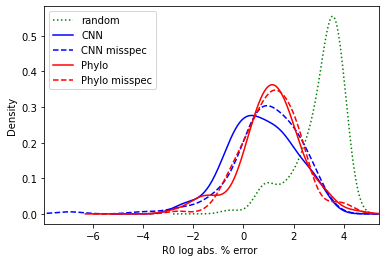

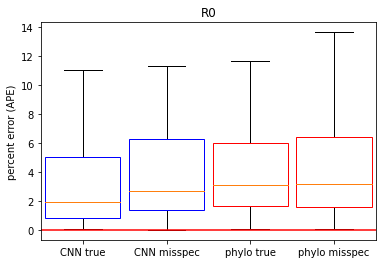

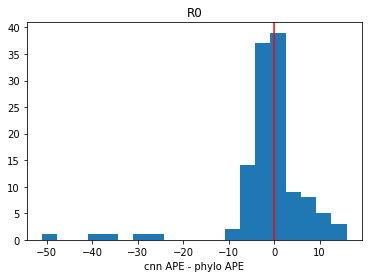

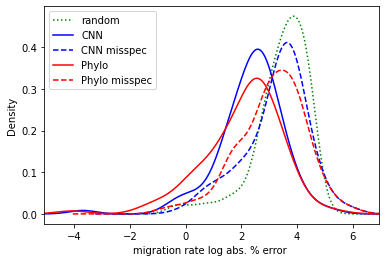

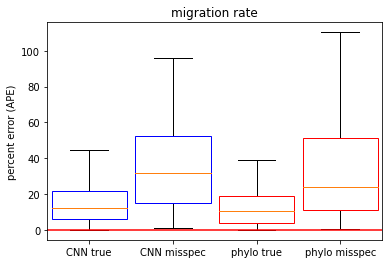

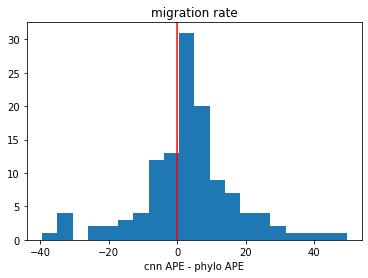

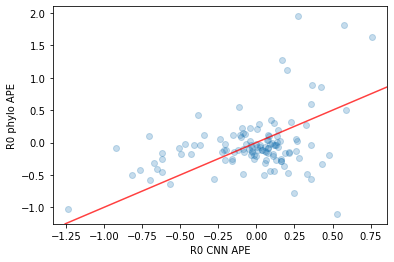

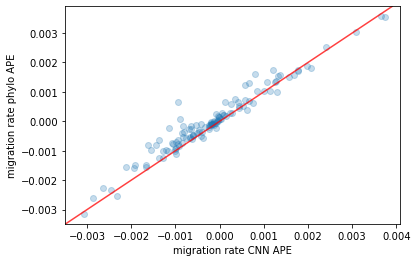

CNN R0:  3.2061589670665116
phylo R0:  11.672719444712058


In [14]:
# phylo mean prediction file
miss_phylo_post_mean = pd.read_table("data_files/phylo_estimates_files/sample_misspec_3params_R0_delta_migr.postmeans", 
                                    index_col=0, header = None).to_numpy()

# compute absolute percent error
miss_phylo_abserror = np.abs(np.subtract(miss_phylo_post_mean, misspec_delta_labels[:,5:8]))
miss_phylo_mape = np.multiply(100, np.abs(np.divide(miss_phylo_abserror, misspec_delta_labels[:,5:8])))


# plot

cn.make_experiment_density_plots(cnn_phylocomp_ape[:,[0,2]], phylo_post_ape[:,[0,2]],
                       miss_mape[:,[0,2]], miss_phylo_mape[:,[0,2]], baseline_ape[:,[0,2]],
                                xlabel = ["R0", "migration rate"])

cn.plot_preds_labels((misspec_delta_denormalized_preds[:,[0,2]] - misspec_delta_labels[:,5:8][:,[0,2]]), 
                     (miss_phylo_post_mean[:,[0,2]] - misspec_delta_labels[:,5:8][:,[0,2]]), 
                     param_names = ["R0", "migration rate"], axis_labels = ['CNN APE', 'phylo APE'])

print("CNN R0: " , np.median(cnn_phylocomp_ape) - np.median(miss_mape[:,0]))
print("phylo R0: " , np.median(miss_phylo_mape) - np.median(phylo_post_ape[:,0]))

In [36]:
print("CNN R0: " , (np.median(miss_mape[:,0]) - np.median(cnn_phylocomp_ape[:,0])))
print("phylo R0: " , (np.median(miss_phylo_mape[:,0]) - np.median(phylo_post_ape[:,0])))

print("CNN m rate: " , (np.median(miss_mape[:,2]) - np.median(cnn_phylocomp_ape[:,2])))
print("phylo m rate: " , (np.median(miss_phylo_mape[:,2]) - np.median(phylo_post_ape[:,2])))

print("\n R0")
print("median difference in APE (CNN_APE - Phylo_APE): ",  np.median(miss_mape[:,0] - miss_phylo_mape[:,0]))
print(np.median(miss_phylo_mape[:,0]), np.quantile(miss_phylo_mape[:,0], [0.025, 0.975]))
print(np.median(miss_mape[:,0]), np.quantile(miss_mape[:,0], [0.025, 0.975]))
print(np.median(baseline_ape[:,0]), np.quantile(baseline_ape[:,0], [0.025, 0.975]))
print("\n migration")
print("median difference in APE (CNN_APE - Phylo_APE): ",  np.median(miss_mape[:,2] - miss_phylo_mape[:,2]))
print(np.median(miss_phylo_mape[:,2]), np.quantile(miss_phylo_mape[:,2], [0.025, 0.975]))
print(np.median(miss_mape[:,2]), np.quantile(miss_mape[:,2], [0.025, 0.975]))
print(np.median(baseline_ape[:,2]), np.quantile(baseline_ape[:,2], [0.025, 0.975]))


CNN R0:  0.7370067252873591
phylo R0:  0.08110535778188233
CNN m rate:  19.51642517604126
phylo m rate:  13.276031154690234

 R0
median difference in APE (CNN_APE - Phylo_APE):  -0.5423752840998911
3.170950152673152 [ 0.44071991 35.47985639]
2.672607447263757 [ 0.08497985 17.38138924]
29.7691 [ 1.99614  56.117725]

 migration
median difference in APE (CNN_APE - Phylo_APE):  3.9357821173752527
24.062751247158992 [  1.26908995 152.73505852]
31.917137781055814 [  1.86057358 145.9486556 ]
37.54939215686275 [ 1.86304706 91.97673725]


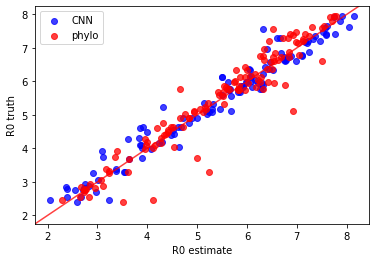

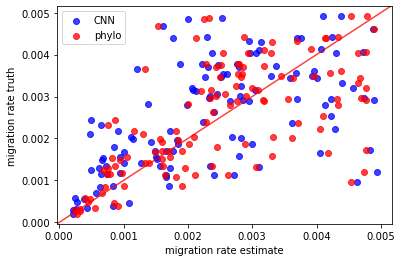

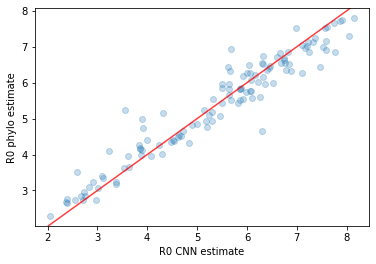

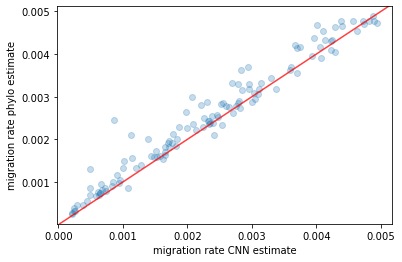

In [17]:
cn.plot_overlaid_scatter(misspec_delta_denormalized_preds[:,[0,2]], miss_phylo_post_mean[:,[0,2]],
                         misspec_delta_labels[:,5:8][:,[0,2]], 
                         param_names = ["R0", "migration rate"])

cn.plot_preds_labels((misspec_delta_denormalized_preds[:,[0,2]]), 
                     (miss_phylo_post_mean[:,[0,2]]), 
                     param_names = ["R0", "migration rate"], axis_labels = ['CNN estimate', 'phylo estimate'])

In [18]:
################################
# misspecified migration rate ##
################################
misspec_migration_data = pd.read_csv("data_files/cblv_files/misspec_migration.cblv.csv", 
                   header =None, error_bad_lines = False).to_numpy()
# load labels data
misspec_migration_labels = pd.read_csv("data_files/label_files/alt_loc_R0_delta_migration_treelength_meanbl_misspec_migration.csv",
                    header = None, error_bad_lines = False, index_col = None).to_numpy()


In [19]:
#########################
# prepare input tensors #
#########################

# normalize with training means and sds
misspec_migration_subsample_prop = misspec_migration_data[:,(max_tips-1) * 7]
misspec_migration_mu = misspec_migration_data[:,(max_tips-3) * 7]
misspec_migration_num_tips = cn.get_num_tips(misspec_migration_data)
misspec_migration_tmrca = misspec_migration_labels[:,8]
misspec_migration_mean_bl = misspec_migration_labels[:,9]

aux_misspec_migration = np.vstack((misspec_migration_mu, misspec_migration_subsample_prop, misspec_migration_num_tips,
                              misspec_migration_tmrca, misspec_migration_mean_bl)).transpose()
norm_aux_misspec_migration = cn.normalize(aux_misspec_migration, (train_aux_priors_means, train_aux_priors_sd))

misspec_migration_treeLocation_tensor, misspec_migration_prior_tensor = cn.create_data_tensors(misspec_migration_data,
                                                                          mu = norm_aux_misspec_migration[:,0],
                                                                          subsample_prop = norm_aux_misspec_migration[:,1],
                                                                            num_tips = norm_aux_misspec_migration[:,2],
                                                                            tmrca = norm_aux_misspec_migration[:,3],
                                                                            mean_bl = norm_aux_misspec_migration[:,4],
                                                                            num_locs = num_locs,
                                                                            max_tips = max_tips,
                                                                            cblv_contains_mu_rho = True)


In [20]:
# predict
miss_migration_normalized_preds = mymodel.predict([misspec_migration_treeLocation_tensor, 
                                         misspec_migration_prior_tensor])

# denormalize preds use label means and sd from training data normalization
miss_migration_denormalized_preds = cn.denormalize(miss_migration_normalized_preds, train_means[0:3], train_sd[0:3])
miss_migration_denormalized_preds[:,1:3] = np.exp(miss_migration_denormalized_preds[:,1:3])

# measure error
miss_migration_abserror = np.abs(np.subtract(miss_migration_denormalized_preds, misspec_migration_labels[:,5:8]))
miss_migration_mape = np.multiply(100, np.abs(np.divide(miss_migration_abserror, misspec_migration_labels[:,5:8])))



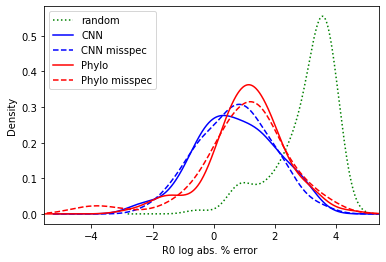

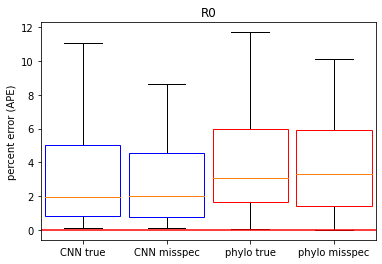

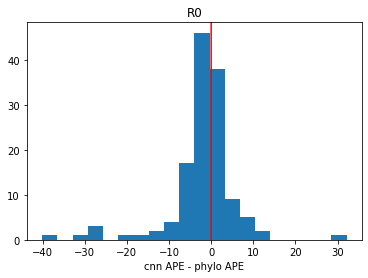

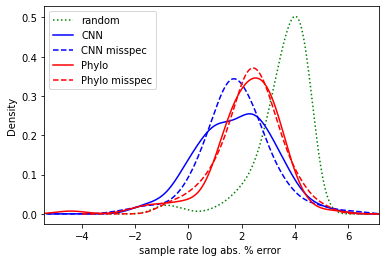

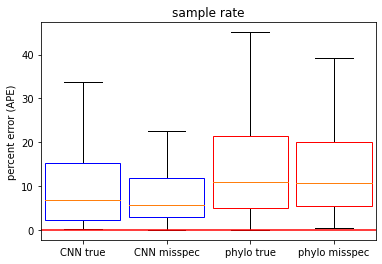

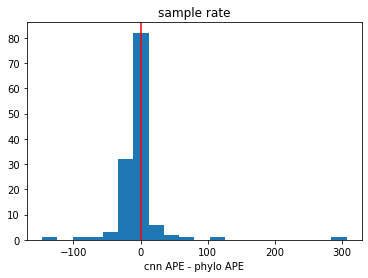

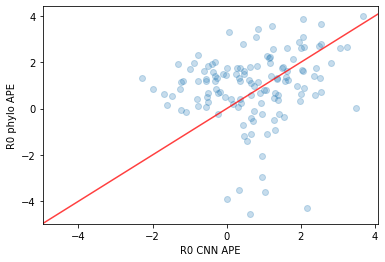

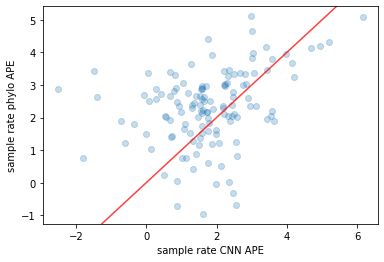

R0
median difference in APE (CNN_APE - Phylo_APE):  -0.9758460427840059
sample rate
median difference in APE (CNN_APE - Phylo_APE):  -3.418393051895012


In [21]:
# phylo mean prediction file
miss_migration_phylo_post_mean = pd.read_table("data_files/phylo_estimates_files/misspec_migration_R0_delta_migration.postmeans",
                                              index_col=0, header = None).to_numpy()
# compute absolute percent error
miss_migration_phylo_abserror = np.abs(np.subtract(miss_migration_phylo_post_mean, 
                                                   misspec_migration_labels[:,5:8]))
miss_migration_phylo_mape = np.multiply(100, np.abs(np.divide(miss_migration_phylo_abserror, 
                                                              misspec_migration_labels[:,5:8])))


# plot
cn.make_experiment_density_plots(cnn_phylocomp_ape[:,[0,1]], phylo_post_ape[:,[0,1]],
                       miss_migration_mape[:,[0,1]], miss_migration_phylo_mape[:,[0,1]],
                           baseline_ape[:,[0,1]],
                                xlabel = ["R0", "sample rate"])

# correlation in error?
cn.plot_preds_labels(np.log(miss_migration_mape[:,[0,1]]), np.log(miss_migration_phylo_mape[:,[0,1]]), 
                     param_names = ["R0", "sample rate"], axis_labels = ['CNN APE', 'phylo APE'])

# summary
print("R0")
print("median difference in APE (CNN_APE - Phylo_APE): ",  np.median(miss_migration_mape[:,0] - miss_migration_phylo_mape[:,0]))


print("sample rate")
print("median difference in APE (CNN_APE - Phylo_APE): ",  np.median(miss_migration_mape[:,1] - miss_migration_phylo_mape[:,1]))


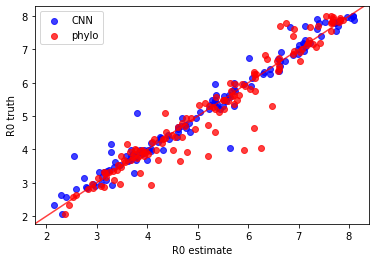

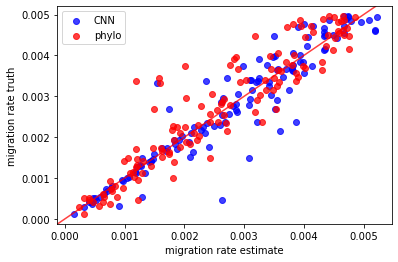

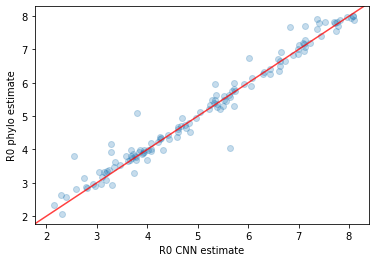

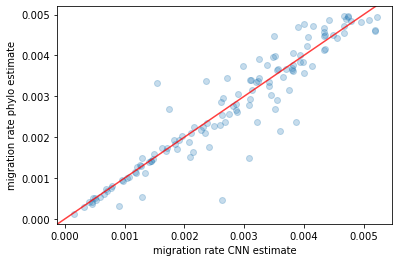

In [22]:
cn.plot_overlaid_scatter(miss_migration_denormalized_preds[:,[0,1]], miss_migration_phylo_post_mean[:,[0,1]],
                         misspec_migration_labels[:,[5,6]], 
                         param_names = ["R0", "migration rate"])

cn.plot_preds_labels((miss_migration_denormalized_preds[:,[0,1]]), 
                     (misspec_migration_labels[:,[5,6]]), 
                     param_names = ["R0", "migration rate"], axis_labels = ['CNN estimate', 'phylo estimate'])

In [23]:
print("CNN R0: " , (np.median(miss_migration_mape[:,0]) - np.median(cnn_phylocomp_ape[:,0])))
print("phylo R0: " , (np.median(miss_migration_phylo_mape[:,0]) - np.median(phylo_post_ape[:,0])))

print("CNN sample rate: " , (np.median(miss_migration_mape[:,1]) - np.median(cnn_phylocomp_ape[:,1])))
print("phylo sample rate: " , (np.median(miss_migration_phylo_mape[:,1]) - np.median(phylo_post_ape[:,1])))



CNN R0:  0.0915242283656914
phylo R0:  0.19939058635379814
CNN sample rate:  -1.175989171161473
phylo sample rate:  -0.16627649607588602


In [24]:
#######################
## misspecified tree ##
#######################
# read cblv data
misspec_tree_cblv = pd.read_csv("data_files/cblv_files/misspec_phylogeny_treescale0.001.cblv.csv",
                    header = None, error_bad_lines = False).to_numpy()
true_tree_cblv = pd.read_csv("data_files/cblv_files/true_phylogeny_treescale0.001.cblv.csv",
                    header = None, error_bad_lines = False).to_numpy()

# read phylo data
misspec_tree_phylo = pd.read_table("data_files/phylo_estimates_files/misspec_phylo_scale0.001_misspectree_3params_R0_delta_migr.postmeans",
                    header = None, error_bad_lines = False, index_col = 0).to_numpy()
true_tree_phylo = pd.read_table("data_files/phylo_estimates_files/misspec_phylo_scale0.001_truetree_3params_R0_delta_migr.postmeans",
                    header = None, error_bad_lines = False, index_col = 0).to_numpy()

# tree distances data
tree_overlap = pd.read_table("data_files/phylo_estimates_files/proportion_branches_shared_scale0.001.txt",
                            header = None).to_numpy()


# read labels
misspec_tree_param_labels = pd.read_csv("data_files/label_files/loc_R0_delta_migration_treelength_meanbl_misspec_tree_scale0.001.csv",
                    header = None, error_bad_lines = False).to_numpy()
true_tree_param_labels = pd.read_csv("data_files/label_files/loc_R0_delta_migration_treelength_meanbl_true_tree_scale0.001.csv",
                    header = None, error_bad_lines = False).to_numpy()


In [25]:
#########################
# prepare input tensors #
#########################

# normalize with training means and sds
misspectree_subsample_prop = misspec_tree_cblv[:,(max_tips-1) * 7]
misspectree_mu = misspec_tree_cblv[:,(max_tips-3) * 7]
misspectree_num_tips = cn.get_num_tips(misspec_tree_cblv)
misspectree_tmrca = misspec_tree_param_labels[:,8]
misspectree_mean_bl = misspec_tree_param_labels[:,9]

aux_misspectree = np.vstack((misspectree_mu, misspectree_subsample_prop, misspectree_num_tips,
                              misspectree_tmrca, misspectree_mean_bl)).transpose()
norm_aux_misspectree = cn.normalize(aux_misspectree, (train_aux_priors_means, train_aux_priors_sd))

misspectree_treeLocation_tensor, misspectree_prior_tensor = cn.create_data_tensors(misspec_tree_cblv,
                                                                          mu = norm_aux_misspectree[:,0],
                                                                          subsample_prop = norm_aux_misspectree[:,1],
                                                                            num_tips = norm_aux_misspectree[:,2],
                                                                            tmrca = norm_aux_misspectree[:,3],
                                                                            mean_bl = norm_aux_misspectree[:,4],
                                                                            num_locs = num_locs,
                                                                            max_tips = max_tips,
                                                                            cblv_contains_mu_rho = True)






# normalize with training means and sds
truetree_subsample_prop = true_tree_cblv[:,(max_tips-1) * 7]
truetree_mu = true_tree_cblv[:,(max_tips-3) * 7]
truetree_num_tips = cn.get_num_tips(true_tree_cblv)
truetree_tmrca = true_tree_param_labels[:,8]
truetree_mean_bl = true_tree_param_labels[:,9]

aux_truetree = np.vstack((truetree_mu, truetree_subsample_prop, truetree_num_tips,
                              truetree_tmrca, truetree_mean_bl)).transpose()
norm_aux_truetree = cn.normalize(aux_truetree, (train_aux_priors_means, train_aux_priors_sd))

truetree_treeLocation_tensor, truetree_prior_tensor = cn.create_data_tensors(true_tree_cblv,
                                                                          mu = norm_aux_truetree[:,0],
                                                                          subsample_prop = norm_aux_truetree[:,1],
                                                                            num_tips = norm_aux_truetree[:,2],
                                                                            tmrca = norm_aux_truetree[:,3],
                                                                            mean_bl = norm_aux_truetree[:,4],
                                                                            num_locs = num_locs,
                                                                            max_tips = max_tips,
                                                                            cblv_contains_mu_rho = True)


In [26]:

# predict
normed_misspec_tree_preds = mymodel.predict([misspectree_treeLocation_tensor, misspectree_prior_tensor])
normed_true_tree_preds = mymodel.predict([truetree_treeLocation_tensor, truetree_prior_tensor])

# denormalize predictions
misspec_tree_preds = cn.denormalize(normed_misspec_tree_preds, train_means[0:3], train_sd[0:3])
misspec_tree_preds[:,1:3] = np.exp(misspec_tree_preds[:,1:3])

true_tree_preds = cn.denormalize(normed_true_tree_preds, train_means[0:3], train_sd[0:3])
true_tree_preds[:,1:3] = np.exp(true_tree_preds[:,1:3])



In [27]:
# cnn prediction error
misstree_pred_abserror = np.abs(np.subtract(misspec_tree_preds, misspec_tree_param_labels[:,5:8]))
truetree_pred_abserror = np.abs(np.subtract(true_tree_preds, true_tree_param_labels[:,5:8]))

misstree_pred_mape = np.multiply(100, np.abs(np.divide(misstree_pred_abserror, misspec_tree_param_labels[:,5:8])))
truetree_pred_mape = np.multiply(100, np.abs(np.divide(truetree_pred_abserror, true_tree_param_labels[:,5:8])))

# phylo inference error
misstree_phylo_abserror = np.abs(np.subtract(misspec_tree_phylo, misspec_tree_param_labels[:,5:8]))
truetree_phylo_abserror = np.abs(np.subtract(true_tree_phylo, true_tree_param_labels[:,5:8]))

misstree_phylo_mape = np.multiply(100, np.abs(np.divide(misstree_phylo_abserror, misspec_tree_param_labels[:,5:8])))
truetree_phylo_mape = np.multiply(100, np.abs(np.divide(truetree_phylo_abserror, true_tree_param_labels[:,5:8])))

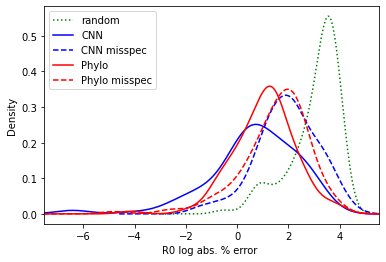

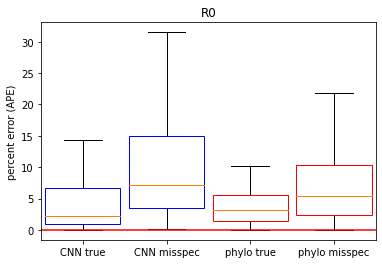

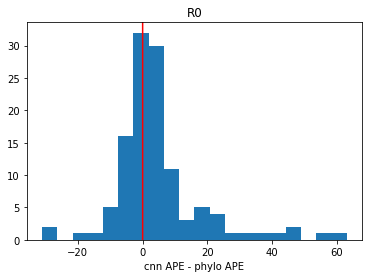

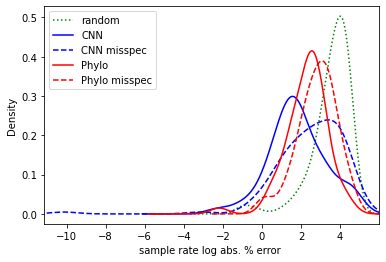

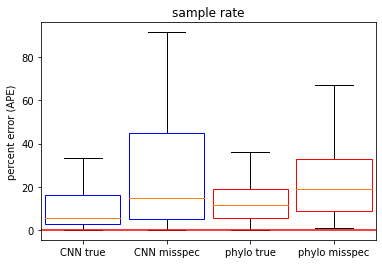

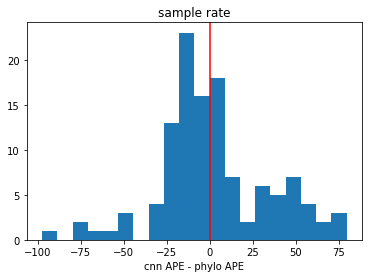

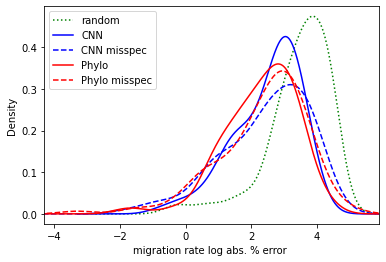

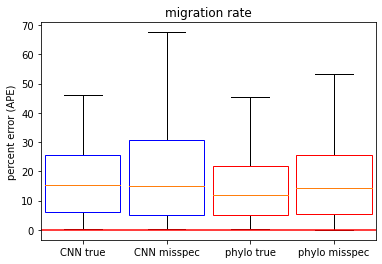

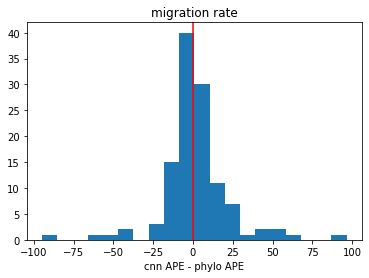

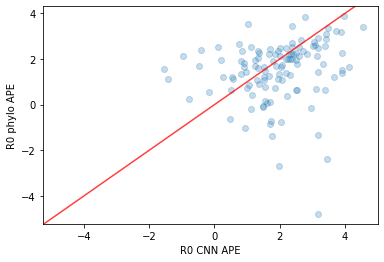

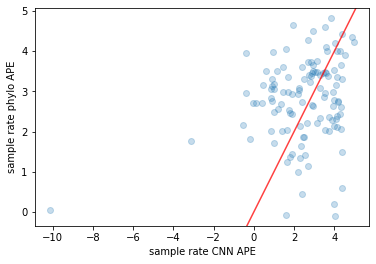

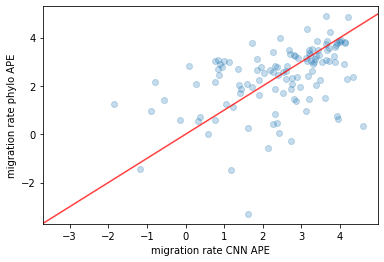

R0
true tree median difference in APE (CNN_APE - Phylo_APE):  -0.5037945495490057
misspec tree median difference in APE (CNN_APE - Phylo_APE):  2.144698196932715
sample rate
true tree median difference in APE (CNN_APE - Phylo_APE):  -3.8392526537722818
misspec tree median difference in APE (CNN_APE - Phylo_APE):  1.9320673499748668
migration rate
true tree median difference in APE (CNN_APE - Phylo_APE):  2.1344747631057395
misspec tree median difference in APE (CNN_APE - Phylo_APE):  -0.024184968860263903


In [38]:
# overlay density plots of reference and treatment group errors
cn.make_experiment_density_plots(truetree_pred_mape, truetree_phylo_mape,
                       misstree_pred_mape, misstree_phylo_mape,
                           baseline_ape)



cn.plot_preds_labels(np.log(misstree_pred_mape), np.log(misstree_phylo_mape), axis_labels = ['CNN APE', 'phylo APE'])

# R0
print("R0")
print("true tree median difference in APE (CNN_APE - Phylo_APE): ",  np.median(truetree_pred_mape[:,0] - truetree_phylo_mape[:,0]))

print("misspec tree median difference in APE (CNN_APE - Phylo_APE): ",  np.median(misstree_pred_mape[:,0] - misstree_phylo_mape[:,0]))

#  sample rate 
print("sample rate")
print("true tree median difference in APE (CNN_APE - Phylo_APE): ",  np.median(truetree_pred_mape[:,1] - truetree_phylo_mape[:,1]))

print("misspec tree median difference in APE (CNN_APE - Phylo_APE): ",  np.mean(misstree_pred_mape[:,1] - misstree_phylo_mape[:,1]))

#  migration rate 
print("migration rate")
print("true tree median difference in APE (CNN_APE - Phylo_APE): ",  np.median(truetree_pred_mape[:,2] - truetree_phylo_mape[:,2]))

print("misspec tree median difference in APE (CNN_APE - Phylo_APE): ",  np.median(misstree_pred_mape[:,2] - misstree_phylo_mape[:,2]))



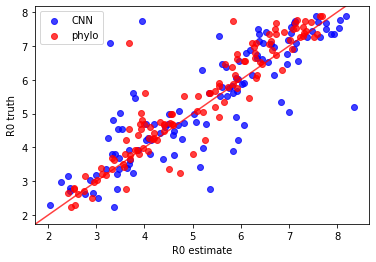

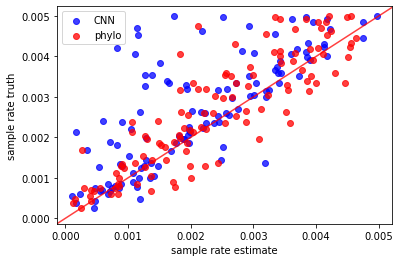

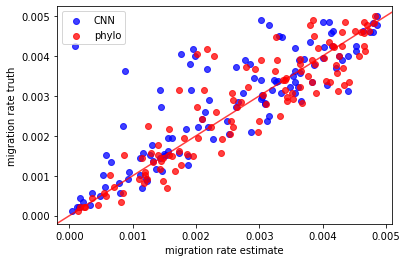

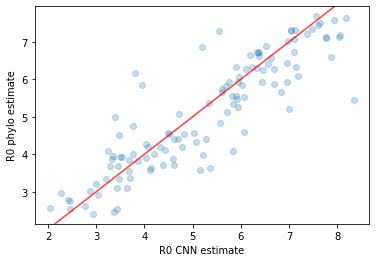

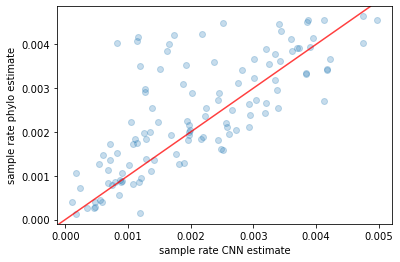

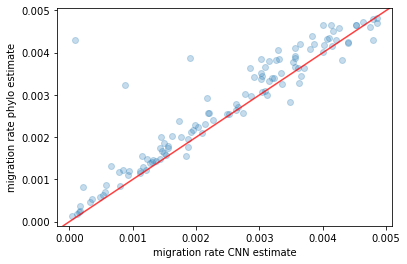

In [29]:
cn.plot_overlaid_scatter(misspec_tree_preds, misspec_tree_phylo,
                         misspec_tree_param_labels[:,5:8], 
                         param_names = ["R0", "sample rate", "migration rate"])

cn.plot_preds_labels((misspec_tree_preds), 
                     (misspec_tree_phylo), 
                     param_names = ["R0", "sample rate", "migration rate"], axis_labels = ['CNN estimate', 'phylo estimate'])

In [30]:
print("CNN R0: " , (np.median(misstree_pred_mape[:,0]-truetree_pred_mape[:,0])))
print("phylo R0: " , (np.median(misstree_phylo_mape[:,0]-truetree_phylo_mape[:,0])))

print("CNN sample rate: " , (np.median(misstree_pred_mape[:,1]-truetree_pred_mape[:,1])))
print("phylo sample rate: " , (np.median(misstree_phylo_mape[:,1]-truetree_phylo_mape[:,1])))

print("CNN m rate: " , (np.median(misstree_pred_mape[:,2]-truetree_pred_mape[:,2])))
print("phylo m rate: " , (np.median(misstree_phylo_mape[:,2]-truetree_phylo_mape[:,2])))



CNN R0:  4.277338610043904
phylo R0:  1.3421088567044985
CNN sample rate:  6.219664716669575
phylo sample rate:  4.817481580229918
CNN m rate:  0.05575143959885298
phylo m rate:  0.9403763079008058


{'name': 'conv1d_13', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3,), 'strides': (1,), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1,), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
(3, 7, 64)
0


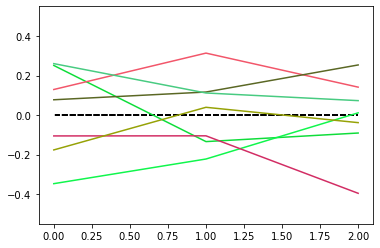

1


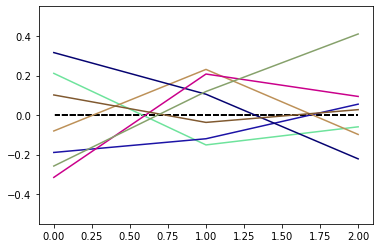

2


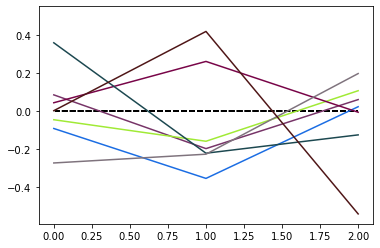

3


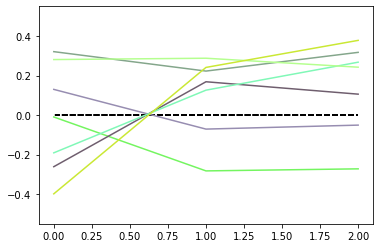

4


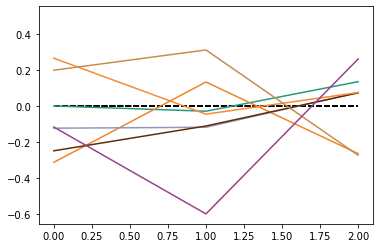

5


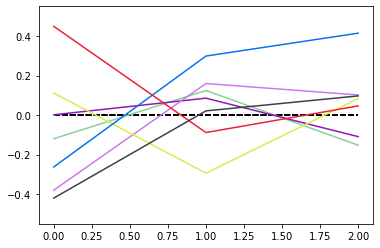

6


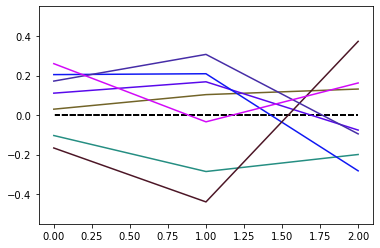

7


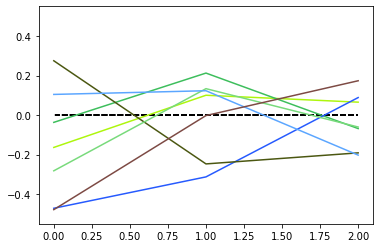

8


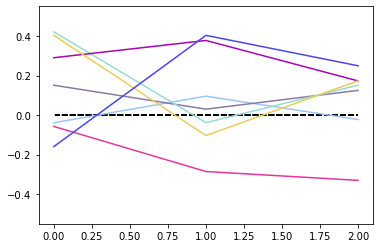

9


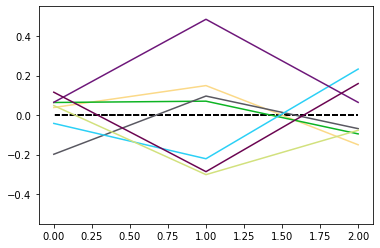

10


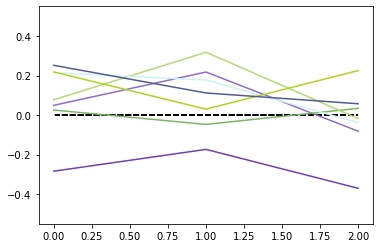

11


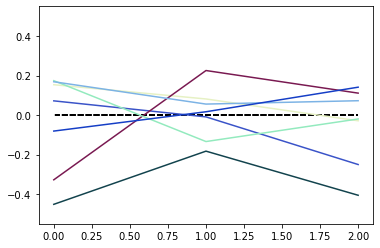

12


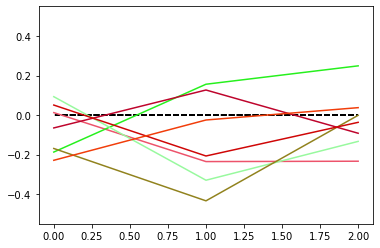

13


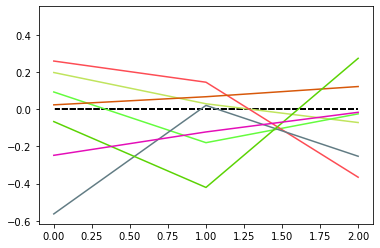

14


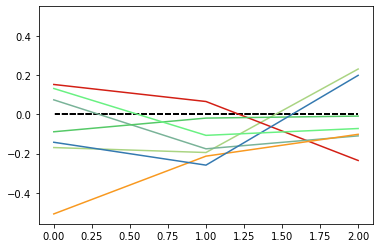

15


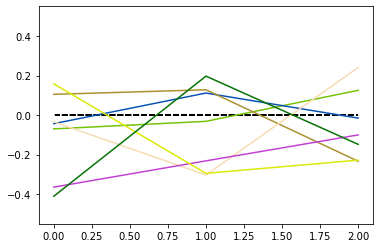

16


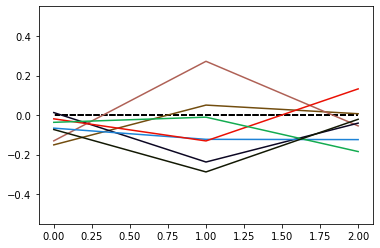

17


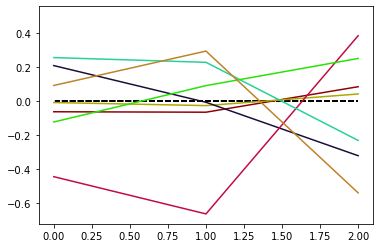

18


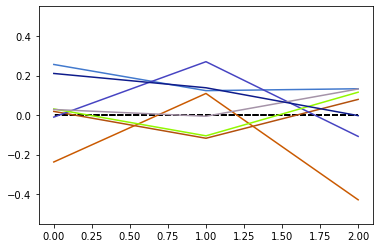

19


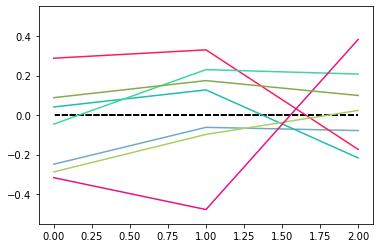

20


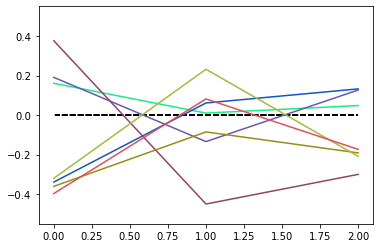

21


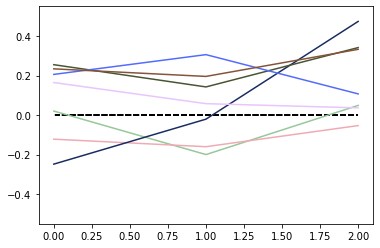

22


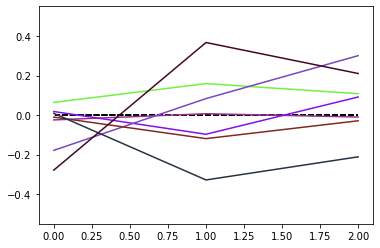

23


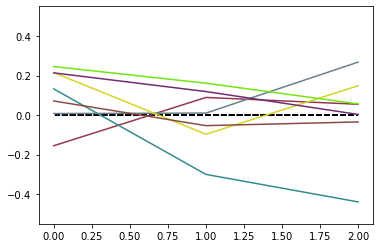

24


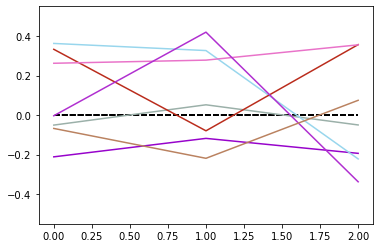

25


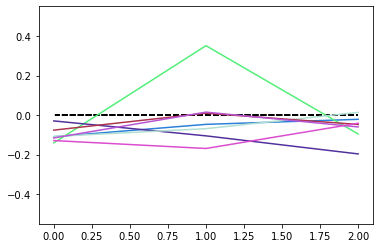

26


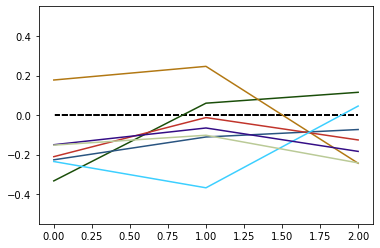

27


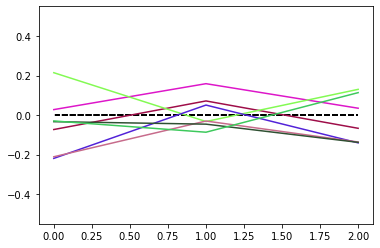

28


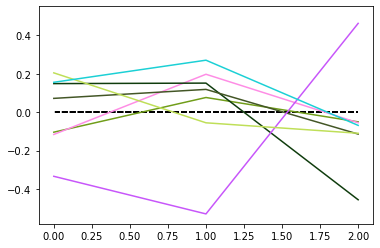

29


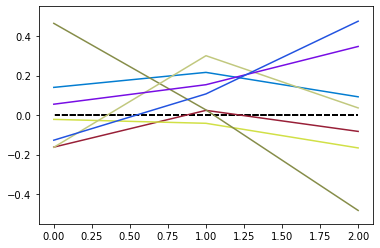

30


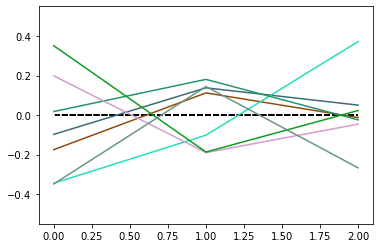

31


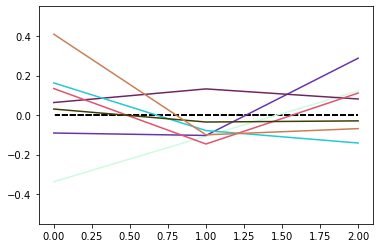

32


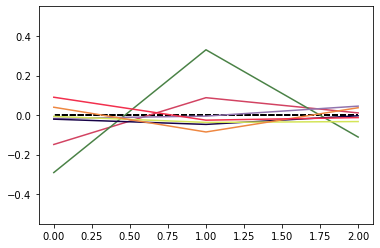

33


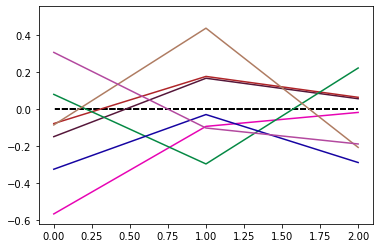

34


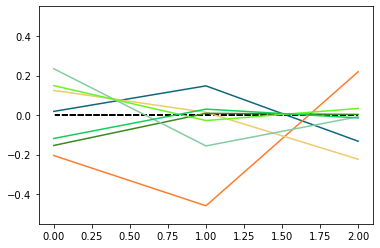

35


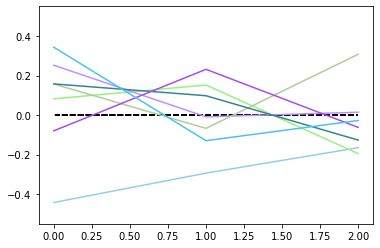

36


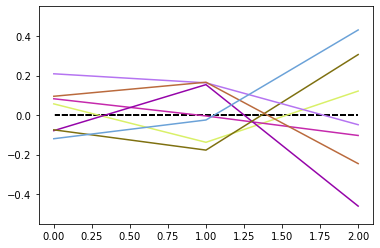

37


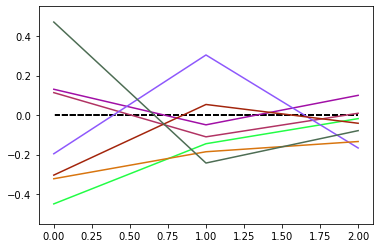

38


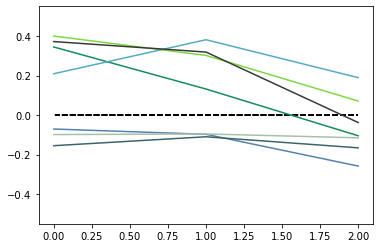

39


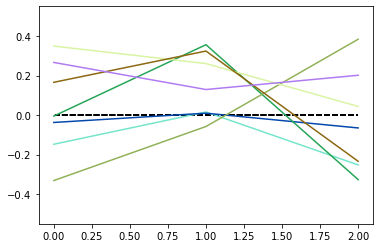

40


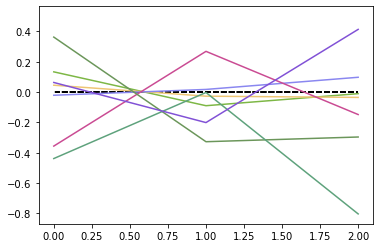

41


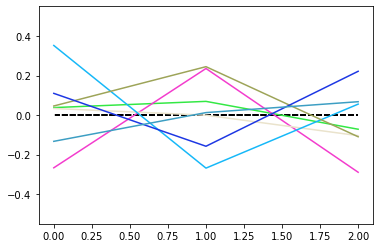

42


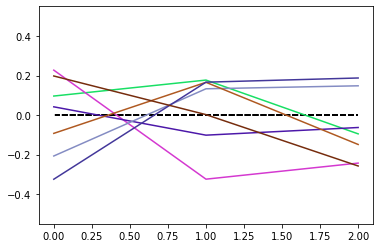

43


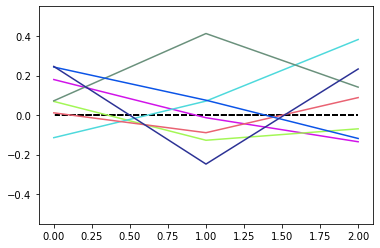

44


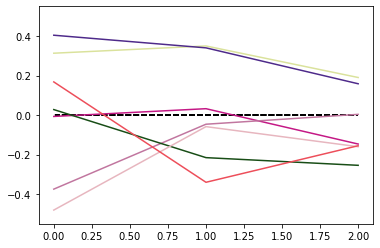

45


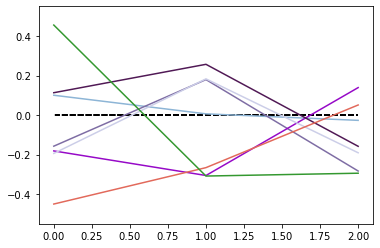

46


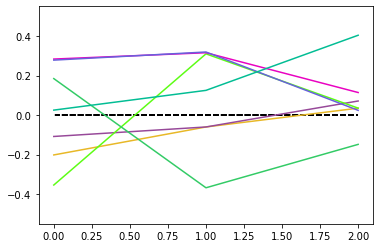

47


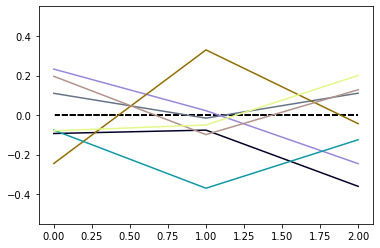

48


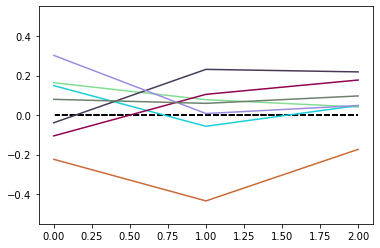

49


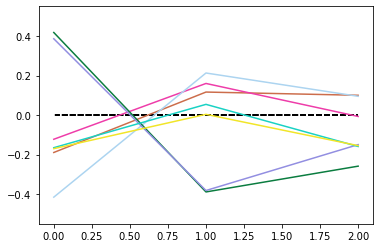

50


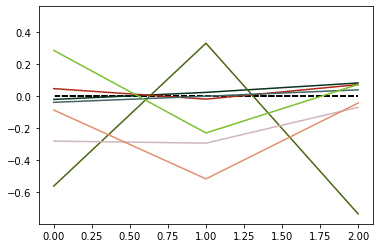

51


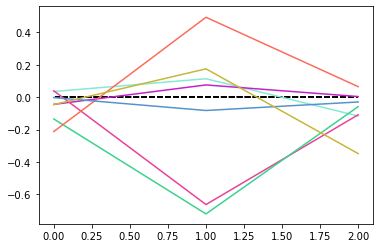

52


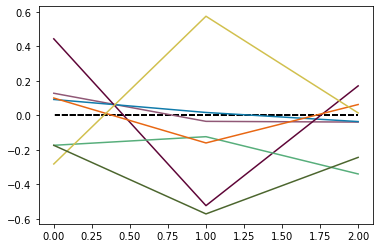

53


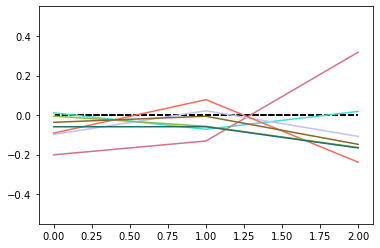

54


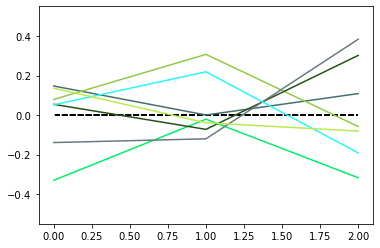

55


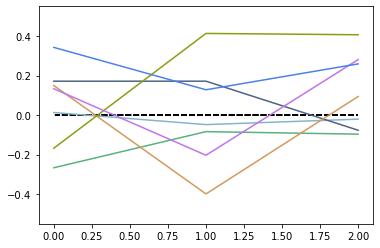

56


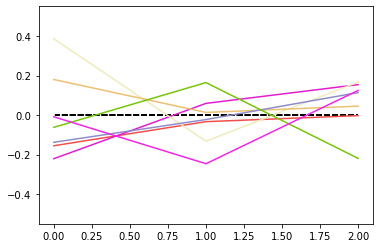

57


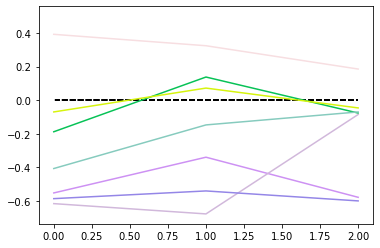

58


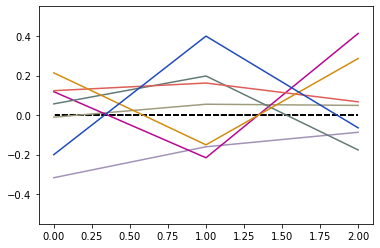

59


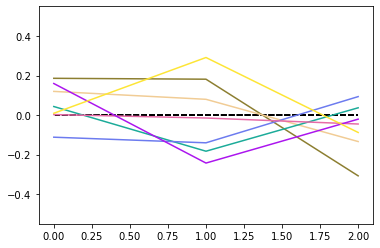

60


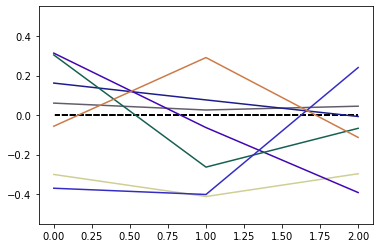

61


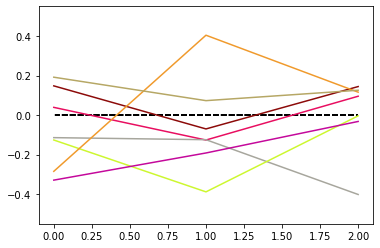

62


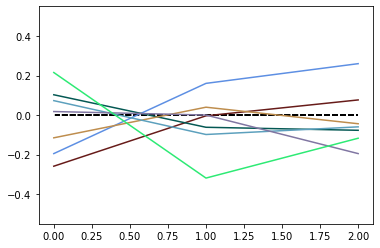

63


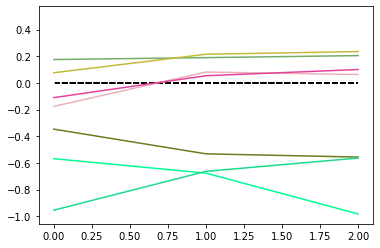

{'name': 'dense_8', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_in', 'distribution': 'normal', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
(128, 64)
0


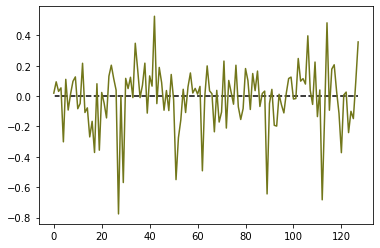

1


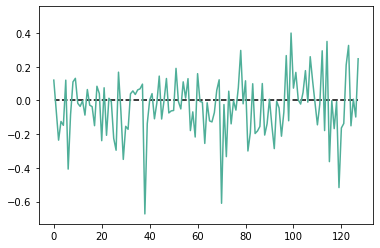

2


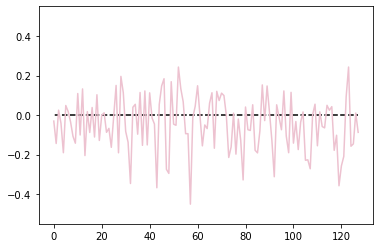

3


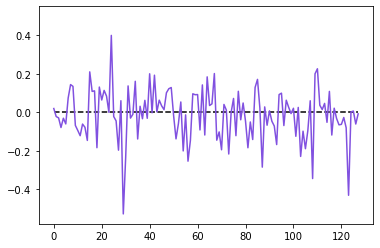

4


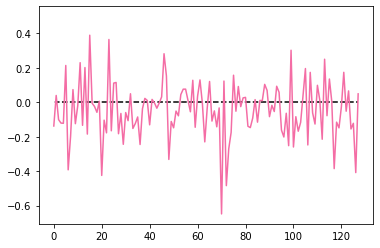

5


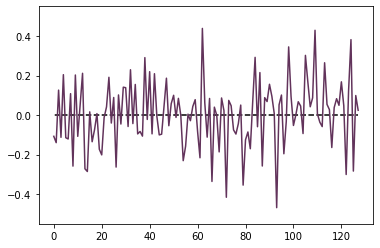

6


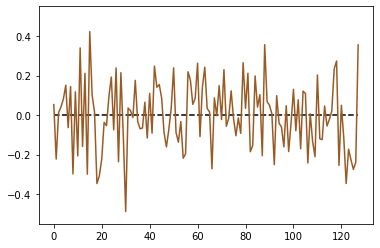

7


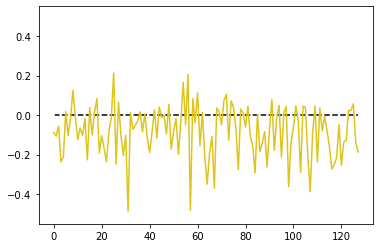

8


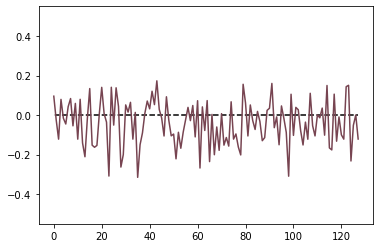

9


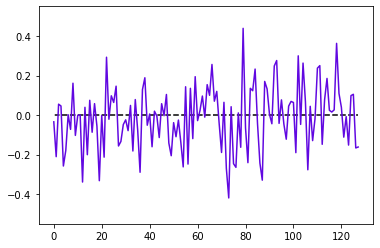

10


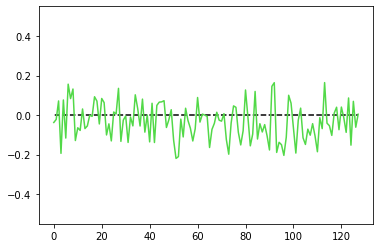

11


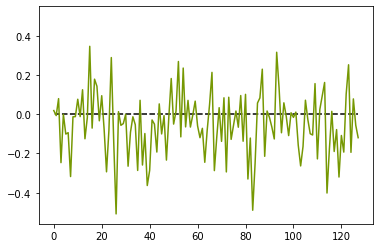

12


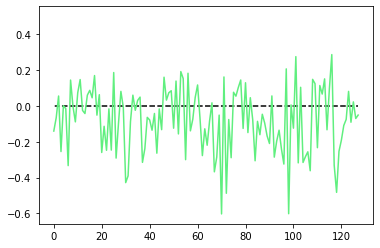

13


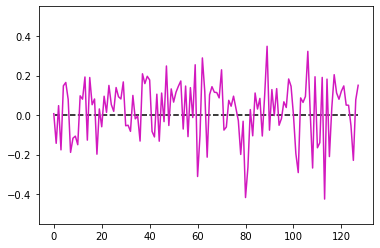

14


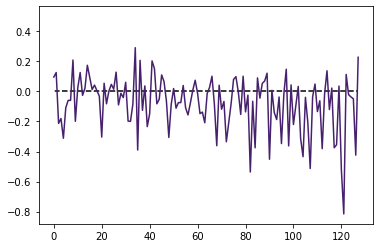

15


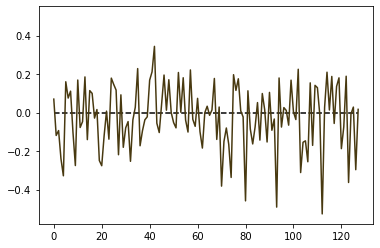

16


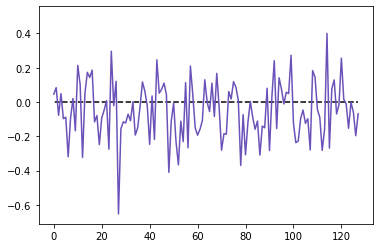

17


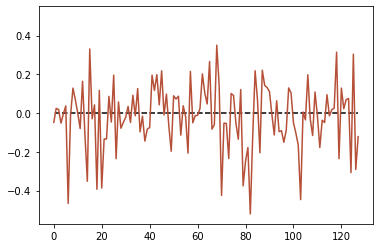

18


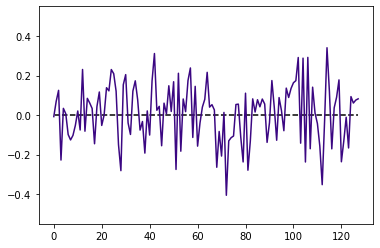

19


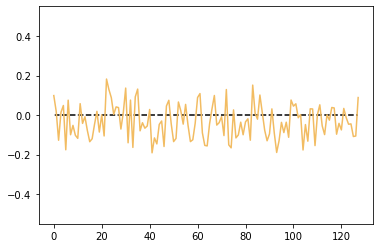

20


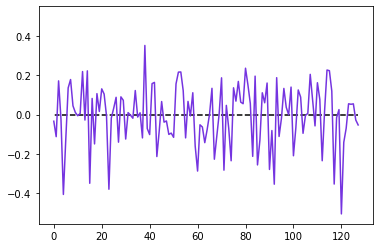

21


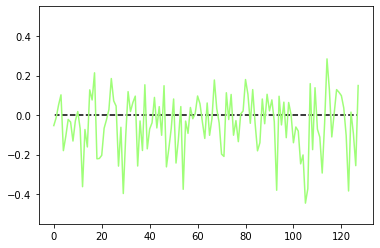

22


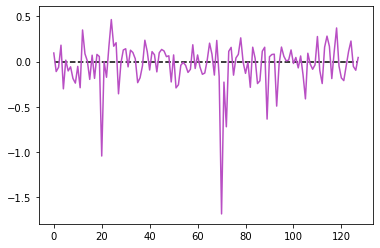

23


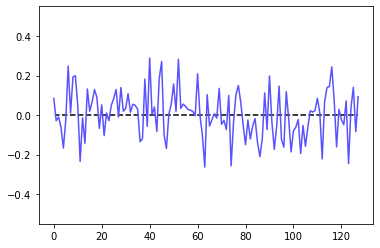

24


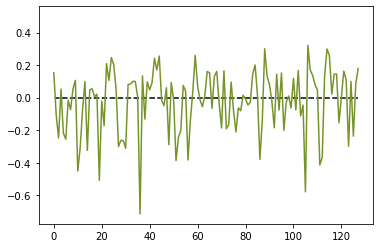

25


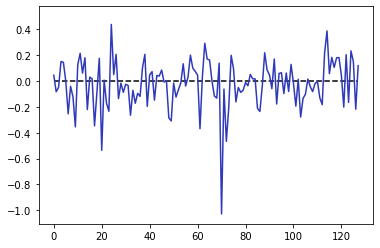

26


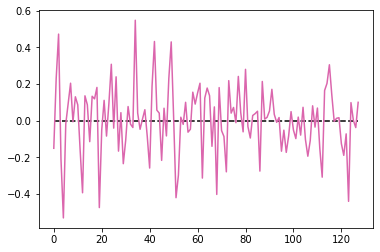

27


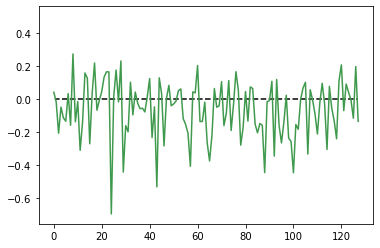

28


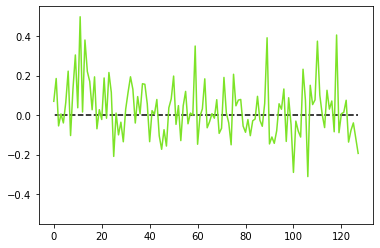

29


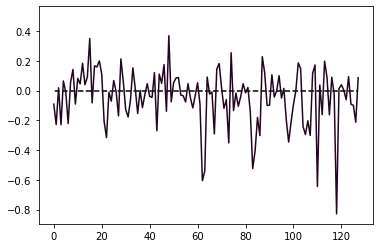

30


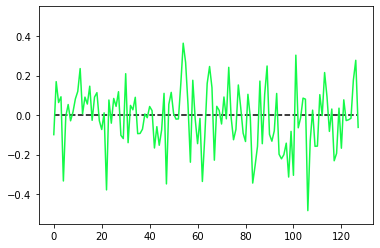

31


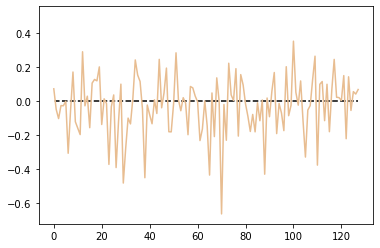

32


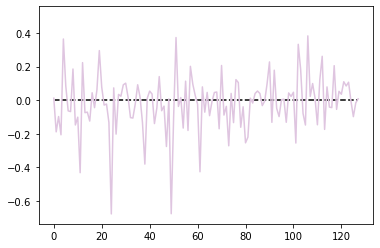

33


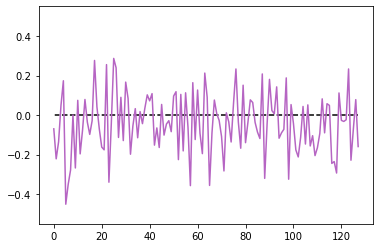

34


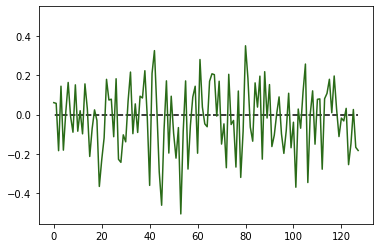

35


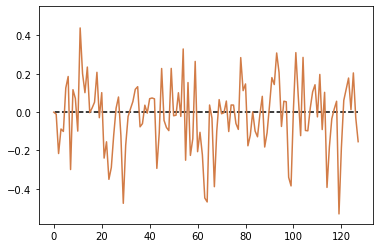

36


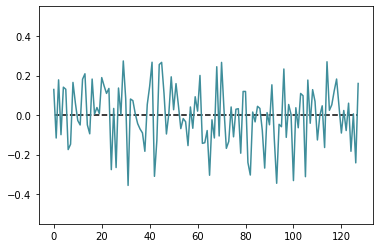

37


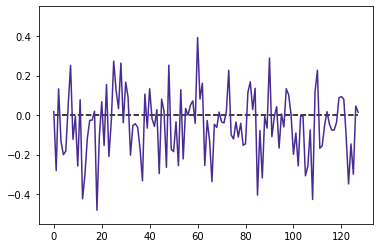

38


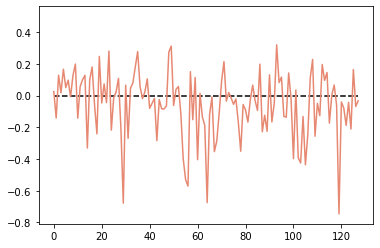

39


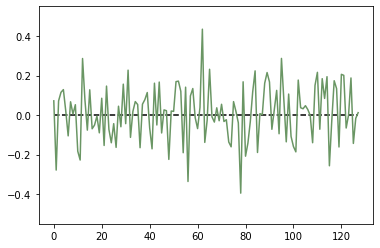

40


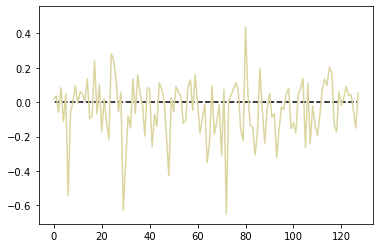

41


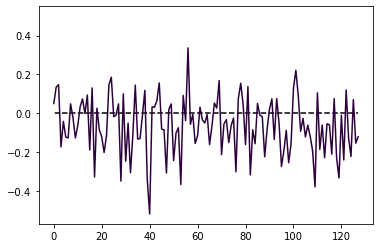

42


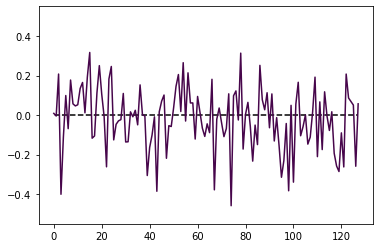

43


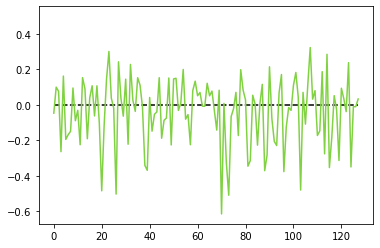

44


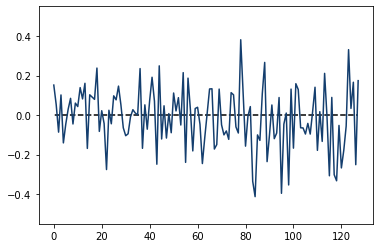

45


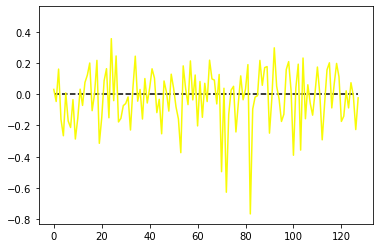

46


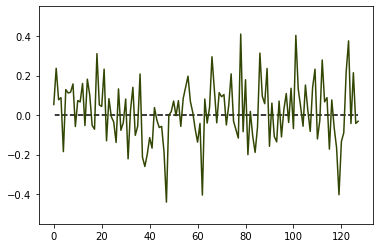

47


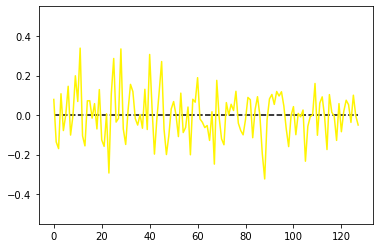

48


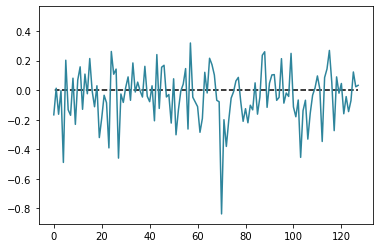

49


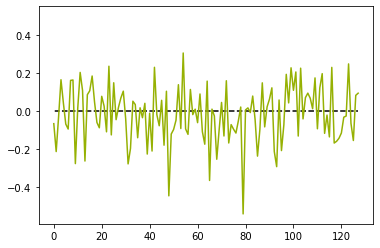

50


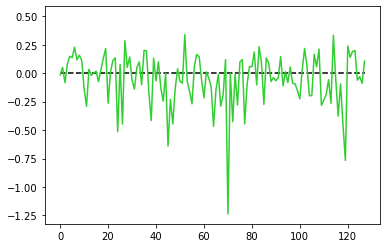

51


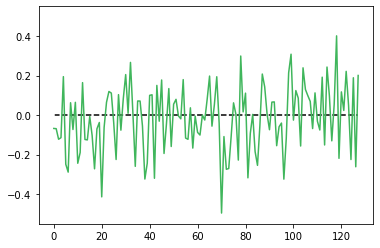

52


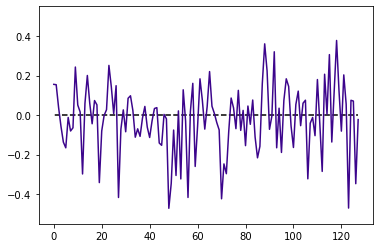

53


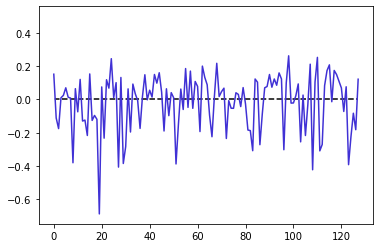

54


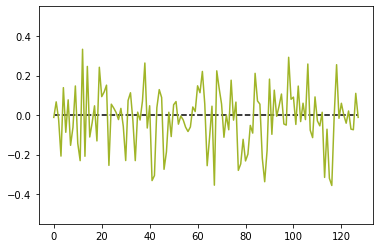

55


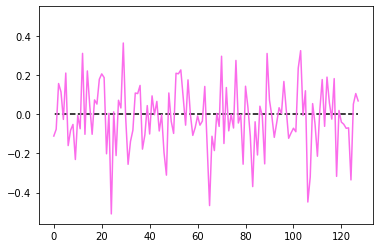

56


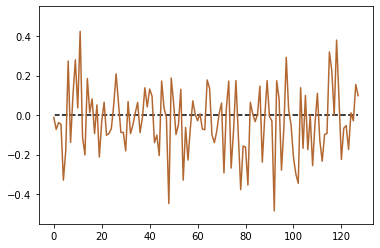

57


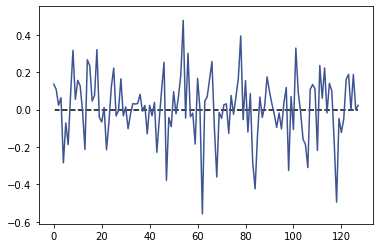

58


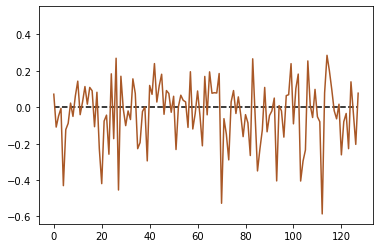

59


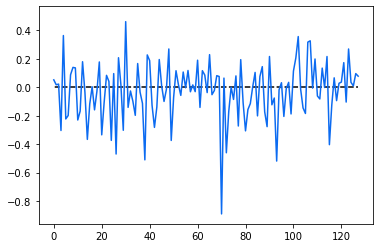

60


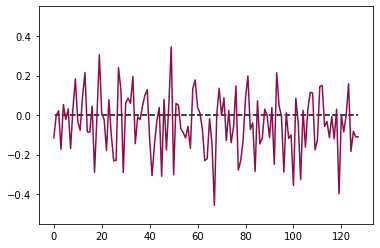

61


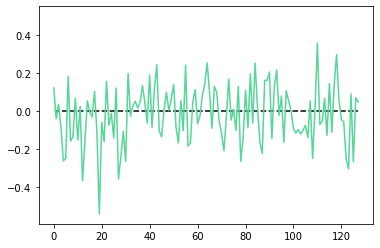

62


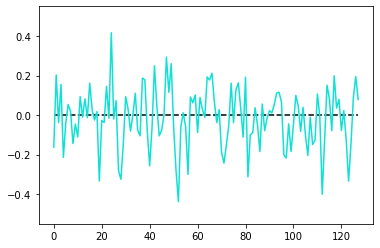

63


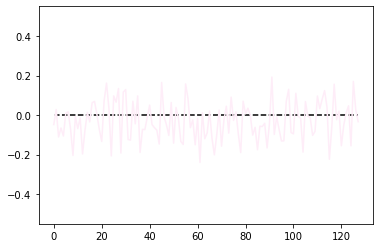

In [31]:
# visualize convolutional layer weights
mymodel.layers
cn.plot_convlayer_weights(mymodel, layer_num = 1)
cn.plot_denselayer_weights(mymodel, layer_num = -3)
